# Tripleten Proyecto Integrado 2: analisis de eventos

Trabajas en una empresa emergente que vende productos alimenticios. Debes investigar el comportamiento del usuario para la aplicación de la empresa.

Primero, estudia el embudo de ventas. Descubre cómo los usuarios y las usuarias llegan a la etapa de compra. ¿Cuántos usuarios o usuarias realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

Luego, observa los resultados de un test A/A/B. Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios y las usuarias piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

## Cargar datos

In [1]:
# Importamos las librerias
from plotly import graph_objects as go
from matplotlib import pyplot as plt
from plotly import express as px
from scipy import stats as st
import seaborn as sns
import pandas as pd
import numpy as np
import math as mth
import datetime

In [2]:
# Cargamos los datos
logs = pd.read_csv('logs_exp_us.csv', sep='\t')
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
# Mostramos info
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


No se observan valores ausentes aparentes

## Preparar datos
 - Cambia el nombre de las columnas de manera que sea conveniente para ti
 - Comprueba si hay tipos de datos y valores ausentes. Corrige los datos si es necesario
 - Agrega una columna de fecha y hora y una columna separada para las fechas

### Cambiar nombre de columnas

In [4]:
# Cambiamos nombres de columnas
logs.rename(columns={
    'EventName': 'name',
    'DeviceIDHash': 'id',
    'EventTimestamp': 'ts',
    'ExpId': 'exp'
}, inplace=True)
logs.head()

,name,id,ts,exp
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Cambiar tipos de dato

In [5]:
# Comprobamos valores de la columna name
logs['name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [6]:
# Cambiamos la columna name a tipo de dato category
logs['name'] = logs['name'].astype('category')
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   name    244126 non-null  category
 1   id      244126 non-null  int64   
 2   ts      244126 non-null  int64   
 3   exp     244126 non-null  int64   
dtypes: category(1), int64(3)
memory usage: 5.8 MB


### Crear las columnas para las fechas

In [7]:
# Creamos una columna para las fecha y hora
logs['date_time'] = pd.to_datetime(logs['ts'], unit='s')
logs.head()

,name,id,ts,exp,date_time
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


In [8]:
# Creamos una columna para las fecha
logs['date'] = logs['date_time'].dt.date
logs.head()

,name,id,ts,exp,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


### Conclusiones
 - Se cambio de nombre las columnas a unos mas utiles
 - Se cambio la columna name a category
 - Se crearon columnas para las fechas

## Estudiar los datos

### Cantidad de eventos

In [9]:
# Contamos la cantidad de eventos en los registros
# por tipo de evento
events = logs.groupby(by='name', as_index=False).count()[['name', 'id']]
events.columns = ['name', 'n_events']
events

C:\Users\ayrto\AppData\Local\Temp\ipykernel_9716\304092091.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  events = logs.groupby(by='name', as_index=False).count()[['name', 'id']]


,name,n_events
0,CartScreenAppear,42731
1,MainScreenAppear,119205
2,OffersScreenAppear,46825
3,PaymentScreenSuccessful,34313
4,Tutorial,1052


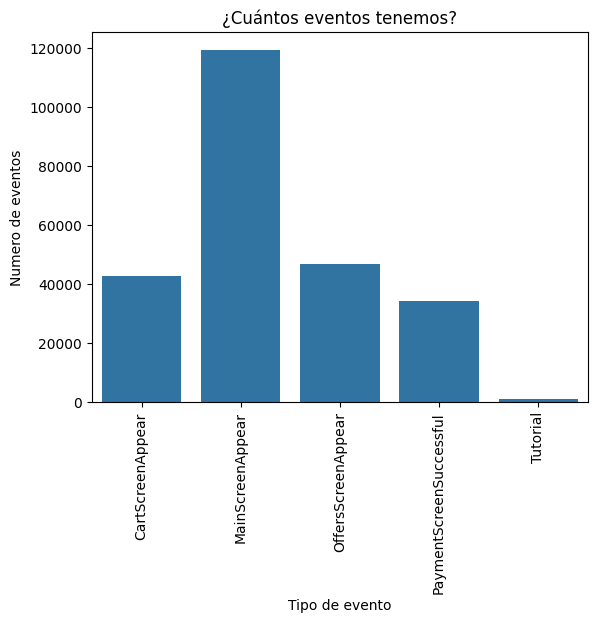

In [10]:
# Grafico de barras
sns.barplot(x='name', y='n_events', data=events)

plt.xlabel('Tipo de evento')
plt.xticks(rotation=90)
plt.ylabel('Numero de eventos')
plt.title('¿Cuántos eventos tenemos?')
plt.show()

In [11]:
# Total de eventos
print('Eventos totales: ', events['n_events'].sum())

Eventos totales:  244126


Contamos con un total de 244126 enventos. El evento mas comun es la pantalla de inicio, lo cual no es una sorpresa. Luego, los eventos van de mayor a menor entre la pantalla de oferta, la pantalla del carrito y la pantalla del pago exitoso.

Si bien los numeros decrecen, estan bastante cerca entre si. Esto indica que entre ellos tenemos una buena conversion. El problema parece ser de la pantalla de inicio a la pantalla de oferta.

### Cantidad de usuarios

In [12]:
# Calculamos la cantidad de usuarios
print('Cantidad total de usuarios: ', logs['id'].nunique())

Cantidad total de usuarios:  7551


Contamos con un total del 7551 usuarios. Podria decirse que a 244126 eventos y 7551 usuarios hay alrededor de 32 eventos por usuario.

### Promedio de eventos por usuario

In [13]:
# Describimos los datos
logs.groupby(by='id').count()['name'].describe()

count    7551.000000
mean       32.330287
std        65.312344
min         1.000000
25%         9.000000
50%        20.000000
75%        37.500000
max      2308.000000
Name: name, dtype: float64

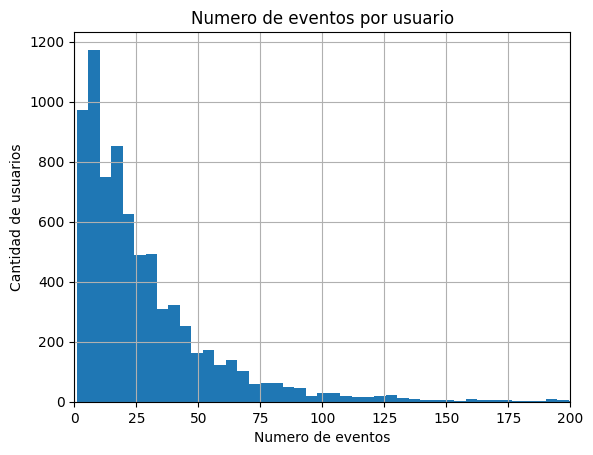

In [14]:
# Graficamos un histograma
logs.groupby(by='id').count()['name'].hist(bins=500)

plt.xlabel('Numero de eventos')
plt.xlim([0, 200])
plt.ylabel('Cantidad de usuarios')
plt.title('Numero de eventos por usuario')
plt.show()

Observamos que hay una poca cantidad de usuarios que realizan muchos eventos, lo que inclina la media hacia arriba. Si nos enfocamos en la mediana, podemos decir que un usario promedio hace alrededor de 20 eventos.

### Linea de tiempo

In [15]:
# Imprimimos la fecha maxima
print('Fecha maxima: ', logs['date'].max())

Fecha maxima:  2019-08-07


In [16]:
# Imprimimos la fecha minima
print('Fecha minima: ', logs['date'].min())

Fecha minima:  2019-07-25


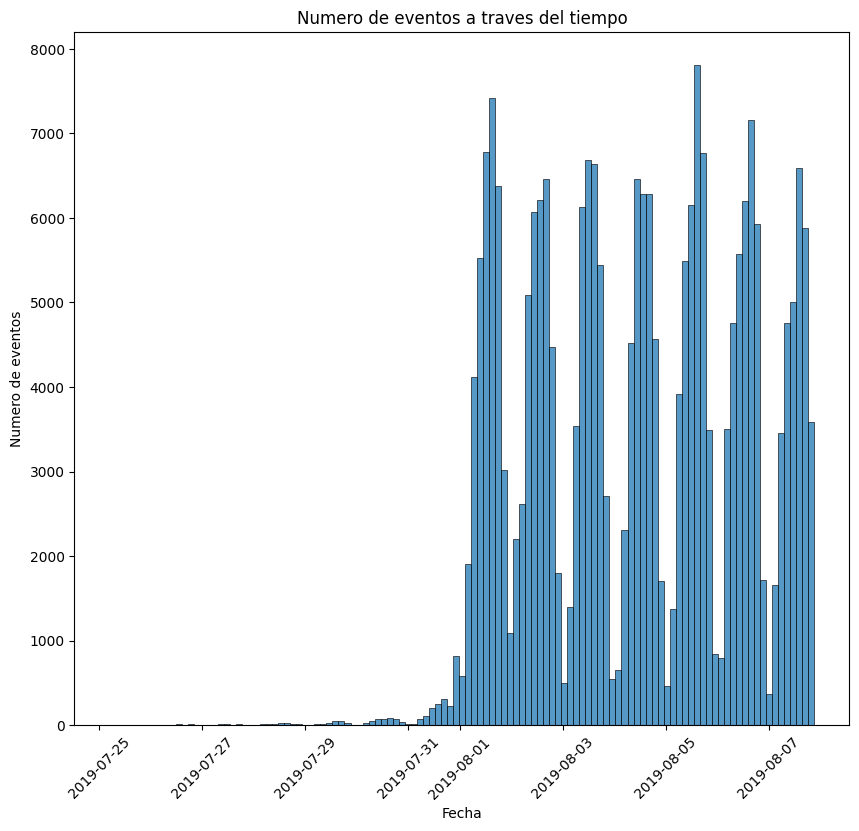

In [17]:
# Graficamos un histograma por fecha y hora
plt.figure(figsize=(10,9))
sns.histplot(data=logs, x='date_time')

plt.xlabel('Fecha')
plt.xticks(rotation=45)
plt.ylabel('Numero de eventos')
plt.title('Numero de eventos a traves del tiempo')
plt.show()

Observamos que la cantidad de eventos al inicio del registro es bastante menor en comparacion a la segunda mitad. Es probable que estos registros esten errados y sesguen nuestro analisis. Es preferible retirarlos y analizar los registros con informacion uniforme.

In [18]:
# Mostramos los datos agrupados por fecha
logs.groupby(by='date').count()['name']

date
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      413
2019-07-31     2031
2019-08-01    36229
2019-08-02    35606
2019-08-03    33351
2019-08-04    33033
2019-08-05    36113
2019-08-06    35822
2019-08-07    31144
Name: name, dtype: int64

In [19]:
# Nos quedamos con el mes de agosto
logs_aug = logs[logs['date'] >= datetime.date(2019,8,1)]
logs_aug = logs_aug.reset_index(drop=True)
logs_aug.head()

,name,id,ts,exp,date_time,date
0,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
1,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
3,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
4,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


Podemos observar que los datos representan en realidad a los eventos registrados durante la primera semana de agosto. Esto debido a que del 31 de julio al primero de agosto hay un salto brusco de 2k eventos registrados a 36k eventos registrados.

Es posible que los primeros registros sean producto de una falla tecnica.

### Eventos y usuarios perdidos

In [20]:
# Eventos totales iniciales
print('Eventos iniciales: ', logs.shape[0])

Eventos iniciales:  244126


In [21]:
# Eventos totales de agosto
print('Eventos de agosto: ', logs_aug.shape[0])

Eventos de agosto:  241298


In [22]:
# Eventos perdidos
print('Eventos perdidos: ', logs.shape[0] - logs_aug.shape[0])

Eventos perdidos:  2828


In [23]:
# Usuarios iniciales
print('Usuarios iniciales: ', logs['id'].nunique())

Usuarios iniciales:  7551


In [24]:
# Usuarios actuales
print('Usuarios actuales: ', logs_aug['id'].nunique())

Usuarios actuales:  7534


In [25]:
# Usuarios perdidos
print('Usuarios perdidos: ', logs['id'].nunique() - logs_aug['id'].nunique())

Usuarios perdidos:  17


En total se perdieron 2828 eventos y 17 usuarios. Esto corresponde al 1% de los eventos y al 0.2% de los usuarios. Estas perdidas con mas que aceptables.

### Cantidad de usuarios por grupo

In [26]:
# Encontramos la cantidad de usuarios por grupo
users_by_exp = logs_aug.groupby(by='exp', as_index=False).agg({'id': 'nunique'})
users_by_exp.columns = ['exp', 'n_users']
users_by_exp

,exp,n_users
0,246,2484
1,247,2513
2,248,2537


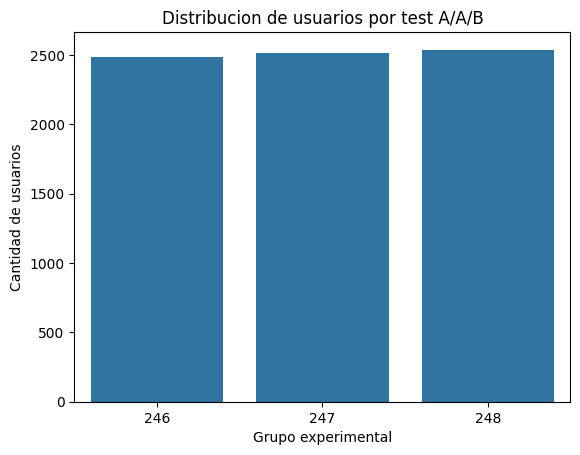

In [27]:
# Graficamos
sns.barplot(data=users_by_exp, x='exp', y='n_users')

plt.xlabel('Grupo experimental')
plt.ylabel('Cantidad de usuarios')
plt.title('Distribucion de usuarios por test A/A/B')
plt.show()

Vemos que contamos con alrededor de 2500 usuarios por cada grupo experimental. Podemos decir que estan bastante uniformemente distribuidos.

### Conclusiones

- Contamos con mas de 240k eventos y alrededor de 7500 usuarios
- En promedio cada usuario realiza alrededor de 20 eventos
- Los datos comprenden el mes de agosto
- Los usuarios estan divididos en 3 grupos de aprox. 2500 usuarios

## Estudiar el embudo

### Tipos de evento por frecuencia

In [28]:
# Mostramos los tipos de evento y su frecuencia en orden descendente
logs_aug['name'].value_counts()

name
MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: count, dtype: int64

Observamos que existen 5 eventos. Ordenados por frecuencia estos son:
 - main screen
 - offers screen
 - cart screen
 - paypent screen
 - tutorial
 
Vemos que el evento mas frecuente es la pantalla principal, lo que tiene sentido. El menos frecuente es el tutorial, lo cual tambien tiene sentido ya que muchas personas lo saltan.

### Numero de usuarios por evento

In [29]:
# Calculamos la cantidad de usuarios unicos que realizaron cada evento
user_by_event = (logs_aug
                 .groupby(by='name', as_index=False)
                 .agg({
                     'id': 'nunique'
                 })
                 .sort_values(by='id', ascending=False).
                 reset_index(drop=True))
user_by_event.columns = ['event', 'n_users']
user_by_event

C:\Users\ayrto\AppData\Local\Temp\ipykernel_9716\3196846505.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(by='name', as_index=False)


,event,n_users
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [30]:
# Calculasmos la proporcion de usuarios totales eb cada evento
total_users = logs_aug['id'].nunique()
user_by_event['proportion_total'] = user_by_event['n_users'] / total_users
user_by_event

,event,n_users,proportion_total
0,MainScreenAppear,7419,0.984736
1,OffersScreenAppear,4593,0.609636
2,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737
4,Tutorial,840,0.111495


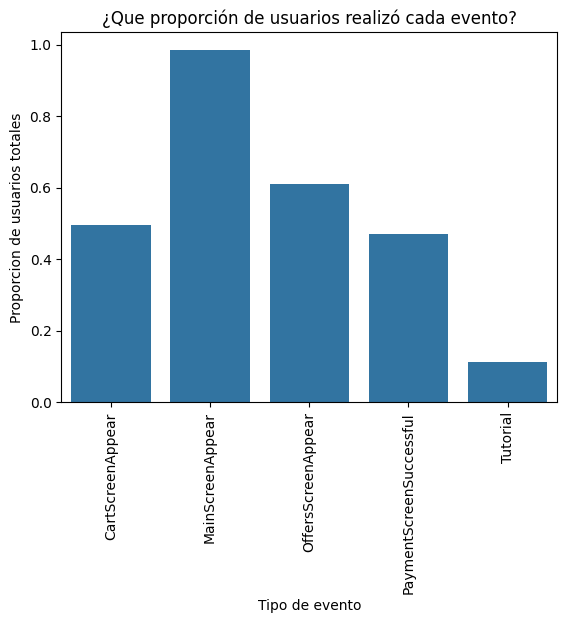

In [31]:
# Grafico de barras
sns.barplot(x='event', y='proportion_total', data=user_by_event)

plt.xlabel('Tipo de evento')
plt.xticks(rotation=90)
plt.ylabel('Proporcion de usuarios totales')
plt.title('¿Que proporción de usuarios realizó cada evento?')
plt.show()

Vemos que no todos los usuarios llegan al menu principal (falta un 2%). Esto podria indicar que algunos usuarios llevan el tutorial, mas no lo terminan y abandonan el proceso; por lo que no llegan al menu principal.

Para el resto de los eventos, entre 47% y 61% de los usuarios o ha realizado al menos una vez.

### Secuencia de los eventos

In [32]:
# Mostramos los eventos
user_by_event

,event,n_users,proportion_total
0,MainScreenAppear,7419,0.984736
1,OffersScreenAppear,4593,0.609636
2,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737
4,Tutorial,840,0.111495


La tabla sugiere que el orden es el siguiente:
 1. Tutorial (no obligatorio)
 2. Pantalla principal
 3. Pantalla de ventas
 4. Pantalla del carrito
 5. Pantalla de pago exitoso
 
El tutorial, al no ser un evento obligatorio, puede ser excluido de la secuencia. Tenemos lo siguiente
 1. Pantalla principal
 2. Pantalla de ventas
 3. Pantalla del carrito
 4. Pantalla de pago exitoso

### Proporcion de usuarios por etapas

In [33]:
# Excluimos el tutorial
user_by_event_no_tutorial = user_by_event[0:4]
user_by_event_no_tutorial

,event,n_users,proportion_total
0,MainScreenAppear,7419,0.984736
1,OffersScreenAppear,4593,0.609636
2,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737


In [34]:
user_by_event_no_tutorial.loc[:, 'proportion_last'] = (user_by_event_no_tutorial['n_users']
                                                       .div(user_by_event_no_tutorial['n_users'].shift(1)))
user_by_event_no_tutorial.loc[0, 'proportion_last'] = 1
user_by_event_no_tutorial

C:\Users\ayrto\AppData\Local\Temp\ipykernel_9716\3844279633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_by_event_no_tutorial.loc[:, 'proportion_last'] = (user_by_event_no_tutorial['n_users']


,event,n_users,proportion_total,proportion_last
0,MainScreenAppear,7419,0.984736,1.000000
1,OffersScreenAppear,4593,0.609636,0.619086
2,CartScreenAppear,3734,0.495620,0.812976
3,PaymentScreenSuccessful,3539,0.469737,0.947777


In [35]:
# Graficamos el embudo
fig = go.Figure(go.Funnel(
    y = user_by_event_no_tutorial['event'],
    x = user_by_event_no_tutorial['n_users']))

fig.show()

Excluimos del analisis al evento Tutorial ya que no es obligatorio. De esta amnera se puede obtener un embudo con los 4 eventos mencionados anteriormente. Se puede obervar que, como es de esperar en un embudo, en cada seccion siguiente hay menos usuarios que en la anterior.

### Etapa de mayor perdida de usuarios

In [36]:
# Mostramos la tabla
user_by_event_no_tutorial

,event,n_users,proportion_total,proportion_last
0,MainScreenAppear,7419,0.984736,1.000000
1,OffersScreenAppear,4593,0.609636,0.619086
2,CartScreenAppear,3734,0.495620,0.812976
3,PaymentScreenSuccessful,3539,0.469737,0.947777


Podemos ver en la tabla que la etapa donde perdemos la mayor cantidad de usuarios es la primera: solo un 62% de los usuarios llega de la pantalla principal a la pantalla de ofertas. Esto quiere decir que 4 de cada 10 usuarios se quedan en la pantalla principal y no continuan usando la aplicacion.

Esto puede ser producto de diversas fuentes, no es posible saber de momento que produce este resultado.

### Porcentaje de usuarios que completan el recorrido

In [37]:
# Graficamos el embudo
fig = go.Figure(go.Funnel(
    y = user_by_event_no_tutorial['event'],
    x = user_by_event_no_tutorial['n_users']))

fig.show()

Como muestra el grafico interactivo: solo un 48% de los clientes realiza el recorrido completo desde la pantalla de inicio hasta la pantalla de compra exitosa. Esto indica que en el camino estamos perdiendo a mas de la mitad de los usuarios.

El problema que tenemos de la pantalla de inicio a la pantalla de ofertas de seguro es el mayor culpable. Observaremos si hay algun cambio de conducta entre los grupos experimentales.

### Conclusiones

 - Contamos con 5 eventos: tutorial, inicio, ofertas, carrito, pago
 - La secuencia es la anterior, descontando el tutorial que es opcional
 - La mayor perdida de usuarios se da entre la pantalla de inidio y las ofertas

## Estudiar los resultados del experimento

### Usuarios por grupo

In [38]:
# Mostramos la tabla
users_by_exp

,exp,n_users
0,246,2484
1,247,2513
2,248,2537


Tenemos alrededor de 2500 usuarios por grupo.

### Diferencias entre grupos control

In [39]:
# Agrupamos a cada grupo de control
exp_246 = logs_aug[logs_aug['exp'] == 246]
exp_247 = logs_aug[logs_aug['exp'] == 247]

display(exp_246.head())
display(exp_247.head())

,name,id,ts,exp,date_time,date
0,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
1,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
3,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
6,OffersScreenAppear,3737462046622621720,1564618226,246,2019-08-01 00:10:26,2019-08-01


,name,id,ts,exp,date_time,date
4,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
5,MainScreenAppear,4899590676214355127,1564618215,247,2019-08-01 00:10:15,2019-08-01
10,MainScreenAppear,4899590676214355127,1564618288,247,2019-08-01 00:11:28,2019-08-01
11,OffersScreenAppear,4899590676214355127,1564618290,247,2019-08-01 00:11:30,2019-08-01
15,OffersScreenAppear,4899590676214355127,1564618356,247,2019-08-01 00:12:36,2019-08-01


In [40]:
# Agrupamos a ambos grupos de control
exp_a = pd.concat([exp_246, exp_247])
exp_a.head()

,name,id,ts,exp,date_time,date
0,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
1,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
3,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
6,OffersScreenAppear,3737462046622621720,1564618226,246,2019-08-01 00:10:26,2019-08-01


In [41]:
# Calculamos la proporcion de usuarios
# que terminan el recorrido completo
# para el grupo 246
users_by_event_246 = (exp_246.groupby(by='name')
                      .agg({'id': 'nunique'})
                      .sort_values(by='id', ascending=False))
users_by_event_246.columns = ['n_users']
display(users_by_event_246)

p1 = (users_by_event_246
      .loc['PaymentScreenSuccessful', 'n_users'] /
      users_by_event_246
      .loc['MainScreenAppear', 'n_users'])
print('Proporcion de usarios exp.246 (P1): ', p1)

C:\Users\ayrto\AppData\Local\Temp\ipykernel_9716\3322483640.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,n_users
name,
MainScreenAppear,2450
OffersScreenAppear,1542
CartScreenAppear,1266
PaymentScreenSuccessful,1200
Tutorial,278


Proporcion de usarios exp.246 (P1):  0.4897959183673469


In [42]:
# Calculamos la proporcion de usuarios
# que terminan el recorrido completo
# para el grupo 247
users_by_event_247 = (exp_247.groupby(by='name')
                      .agg({'id': 'nunique'})
                      .sort_values(by='id', ascending=False))
users_by_event_247.columns = ['n_users']
display(users_by_event_247)

p2 = (users_by_event_247
      .loc['PaymentScreenSuccessful', 'n_users'] /
      users_by_event_247
      .loc['MainScreenAppear', 'n_users'])
print('Proporcion de usarios exp.247 (P2): ', p2)

C:\Users\ayrto\AppData\Local\Temp\ipykernel_9716\2828967531.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,n_users
name,
MainScreenAppear,2476
OffersScreenAppear,1520
CartScreenAppear,1238
PaymentScreenSuccessful,1158
Tutorial,283


Proporcion de usarios exp.247 (P2):  0.4676898222940226


In [43]:
# Calculamos la proporcion de usuarios
# que terminan el recorrido completo
# para todo el grupo A
users_by_event_a = (exp_a.groupby(by='name')
                    .agg({'id': 'nunique'})
                    .sort_values(by='id', ascending=False))
users_by_event_a.columns = ['n_users']
display(users_by_event_a)

p = (users_by_event_a
      .loc['PaymentScreenSuccessful', 'n_users'] /
      users_by_event_a
      .loc['MainScreenAppear', 'n_users'])
print('Proporcion de usarios grupo A (P): ', p)

C:\Users\ayrto\AppData\Local\Temp\ipykernel_9716\4070742918.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,n_users
name,
MainScreenAppear,4926
OffersScreenAppear,3062
CartScreenAppear,2504
PaymentScreenSuccessful,2358
Tutorial,561


Proporcion de usarios grupo A (P):  0.47868453105968334


In [44]:
# Definimos nuestro estadistico para proporciones
# Asumimos que las proporciones poblacionales son iguales
n1 = (users_by_event_246
      .loc['MainScreenAppear', 'n_users'])
n2 = (users_by_event_247
      .loc['MainScreenAppear', 'n_users'])
        
z = (p1 - p2) / mth.sqrt(p * (1 - p) * (1/n1 + 1/n2))

print('Valor del estadistico para proporciones (Z): ', z)

Valor del estadistico para proporciones (Z):  1.5529168745114943


In [45]:
# Calculamos el p-value
norm_distr = st.norm(0, 1)
p_value = (1 - norm_distr.cdf(abs(z))) * 2

print('El p-value es: ', p_value)

El p-value es:  0.12044299485641763


Segun el analisis hecho, obtenemos los siguientes resultados:
 - El 49% de los usuarios en el grupo 246 termina el recorrido
 - El 47% de los usuarios en el grupo 247 termina el recorrido
 - El 48% de los usuarios en el grupo A (246 y 247 juntos) termia el recorrido
 - Existe un 12% de probabilidad de que exista esta diferencia en proporciones
 
Dado que la probabilidad de exista este 2% de diferencia entre las proporciones de las muestras es alta (superior a un alpha de 5% e incluso un alpha de 10%), podemos concluir que las proporciones de ambas muestras son iguales (no podemos rechazar la hipotesis nula de que ambas muestras poseen la misma proporcion).

### Diferencias en las proporciones en cada evento

In [46]:
# Encontramos el evento mas popular entre los grupos de control
display(exp_a['name'].value_counts())

# Excluimos la pantalla de inicio
pop_event = exp_a['name'].value_counts().index[1]

print('Evento mas popular: ', pop_event)

name
MainScreenAppear           76831
OffersScreenAppear         29955
CartScreenAppear           27167
PaymentScreenSuccessful    21953
Tutorial                     666
Name: count, dtype: int64

Evento mas popular:  OffersScreenAppear


In [47]:
# Definimos una funcion
# Determinamos la significancia estadistica
# Entre las proporciones de cada muestra
def stat_significance_proportions(samp_a, samp_b):
    succ_a = samp_a[0]    #cantidad de usuarios que realizan la accion en la muestra A
    tot_a = samp_a[1]     #usuarios totales de la muestra A
    succ_b = samp_b[0]    #cantidad de usuarios que realizan la accion en la muestra B
    tot_b = samp_b[1]     #usuarios totales de la muestra B
    
    p_a = succ_a / tot_a  #proporcion de usuarios que realiza la accion en la muestra A
    p_b = succ_b / tot_b  #proporcion de usuarios que realiza la accion en la muestra B
    p_comb = ((succ_a + succ_b) / 
              (tot_a + tot_b)) #proporcion  total de usuarios que realiza la accion 
    
    z = ((p_a - p_b) / 
         mth.sqrt(p_comb * (1 - p_comb) * (1/tot_a + 1/tot_b))) #estadistico
    
    norm_distr = st.norm(0, 1)
    p_value = (1 - norm_distr.cdf(abs(z))) * 2 #p_value
    
    return (z, p_value)
    
    

In [48]:
# Preparamos las muestras
samp_246 = [users_by_event_246
            .loc[pop_event, 'n_users'],
           users_by_event_246
            .loc['MainScreenAppear', 'n_users']]
samp_247 = [users_by_event_247
            .loc[pop_event, 'n_users'],
           users_by_event_247
            .loc['MainScreenAppear', 'n_users']]

print(samp_246)
print(samp_247)

[1542, 2450]
[1520, 2476]


In [49]:
# Llamamos a la funcion
res_offers = stat_significance_proportions(samp_246, samp_247)

print('El valor del estadistico es: ', res_offers[0])
print('p_value: ', res_offers[1])

El valor del estadistico es:  1.1211253819992044
p_value:  0.2622344959255778


Vemos que segun el analisis realizado, existe un 26% de probabilidad de obtener la diferencia observada entre las muestras para la proporcion de usuarios que llega a la pantalla de ofertas; nada fuera de lo comun.

In [50]:
# Se repite el proceso para la pantalla del carrito
samp_246 = [users_by_event_246
            .loc['CartScreenAppear', 'n_users'],
           users_by_event_246
            .loc['MainScreenAppear', 'n_users']]
samp_247 = [users_by_event_247
            .loc['CartScreenAppear', 'n_users'],
           users_by_event_247
            .loc['MainScreenAppear', 'n_users']]

print(samp_246)
print(samp_247)

[1266, 2450]
[1238, 2476]


In [51]:
# Llamamos a la funcion
res_cart = stat_significance_proportions(samp_246, samp_247)

print('El valor del estadistico es: ', res_cart[0])
print('p_value: ', res_cart[1])

El valor del estadistico es:  1.1746787347900784
p_value:  0.24012327015939383


Segun el analisis realizado, existe un 24% de probabilidad de obtener la diferencia observada entre las muestras para la proporcion de usuarios que llega a la pantalla del carrito; bastante ordinario.

In [52]:
# Se repite el proceso para el tutorial
samp_246 = [users_by_event_246
            .loc['Tutorial', 'n_users'],
           users_by_event_246
            .loc['MainScreenAppear', 'n_users']]
samp_247 = [users_by_event_247
            .loc['Tutorial', 'n_users'],
           users_by_event_247
            .loc['MainScreenAppear', 'n_users']]

print(samp_246)
print(samp_247)

[278, 2450]
[283, 2476]


In [53]:
# Llamamos a la funcion
res_tut = stat_significance_proportions(samp_246, samp_247)

print('El valor del estadistico es: ', res_tut[0])
print('p_value: ', res_tut[1])

El valor del estadistico es:  -0.0914517446661978
p_value:  0.927133647669905


Incluso para el tutorial, el cual es opcional, vemos que las proporciones son consistentes entre sí (93% de probabilidad de obtener la diferencia en proporcions observada.

Podemos concluir que la prueba A/A ha sido exitosa y que los grupos de control fueron divididos exitosamente: ambos grupos son equivalentes.

### Diferencias en proporciones para el grupo de testeo

In [54]:
# Agrupamos al grupo de testeo
exp_248 = logs_aug[logs_aug['exp'] == 248]
exp_248.head()

,name,id,ts,exp,date_time,date
16,MainScreenAppear,4613461174774205834,1564618471,248,2019-08-01 00:14:31,2019-08-01
17,MainScreenAppear,4613461174774205834,1564618474,248,2019-08-01 00:14:34,2019-08-01
18,CartScreenAppear,4613461174774205834,1564618474,248,2019-08-01 00:14:34,2019-08-01
19,PaymentScreenSuccessful,4613461174774205834,1564618483,248,2019-08-01 00:14:43,2019-08-01
20,OffersScreenAppear,4613461174774205834,1564618491,248,2019-08-01 00:14:51,2019-08-01


In [55]:
# Agrupamos los usuarios unicos en cada evento
users_by_event_248 = (exp_248.groupby(by='name')
                      .agg({'id': 'nunique'})
                      .sort_values(by='id', ascending=False))
users_by_event_248.columns = ['n_users']
users_by_event_248

C:\Users\ayrto\AppData\Local\Temp\ipykernel_9716\3744539692.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,n_users
name,
MainScreenAppear,2493
OffersScreenAppear,1531
CartScreenAppear,1230
PaymentScreenSuccessful,1181
Tutorial,279


In [56]:
# Graficamos el embudo del exp248 para observar las proporciones
fig = go.Figure(go.Funnel(
    y = users_by_event_248.index,
    x = users_by_event_248['n_users']))

fig.show()

In [57]:
# Graficamos el embudo del exp 246 y comparamos proporciones
fig = go.Figure(go.Funnel(
    y = users_by_event_246.index,
    x = users_by_event_246['n_users']))

fig.show()

Observamos que existen ligeras diferencias entre las proporciones del primer grupo de control (exp 246) y el grupo de testeo (exp 248). Procedemos a analizar si estas diferencias observadas son estadisticamente significativas.

In [58]:
# Se preparan la lista con los eventos
events = users_by_event_248.index.to_list()
events

['MainScreenAppear',
 'OffersScreenAppear',
 'CartScreenAppear',
 'PaymentScreenSuccessful',
 'Tutorial']

In [59]:
# Se prepara un bucle sobre los eventos
results_246_248 = []
for event in events:
    if (event == 'MainScreenAppear'):
        # Se guardan los usuarios totales en 246
        total_246 = (users_by_event_246
                     .loc[event, 'n_users'])
        # Se guardan los usuarios totales en 248
        total_248 = (users_by_event_248
                     .loc[event, 'n_users'])
        continue
    else:
        # Se prepara la muestra 246 para cada evento
        samp_246 = [users_by_event_246
                    .loc[event, 'n_users'],
                    total_246]
        # Se prepara la muestra 248 para cada evento
        samp_248 = [users_by_event_248
                    .loc[event, 'n_users'],
                    total_248]
        
        # Se obtienen los resultados para cada evento
        results = stat_significance_proportions(samp_246, samp_248)
        results_246_248.append(results)
        
        # Se imprimen los resultados para cada evento
        print('El p_value para el {evento} es: {p}'.format(evento=event, p=results[1]))

El p_value para el OffersScreenAppear es: 0.2684281587249231
El p_value para el CartScreenAppear es: 0.1006104270048993
El p_value para el PaymentScreenSuccessful es: 0.2582638437556217
El p_value para el Tutorial es: 0.8626672274025511


Observamos que los p_values son bastante altos (mayores o iguales que 10%). Esto nos indica que las proporciones de cada evento con respecto al total son bastante similares en el grupo de testeo y en este grupo de control. Las diferencias en proporciones observadas en los embudos no son estadisticamente significativas.

Procedemos a comparar con el otro grupo de control.

In [60]:
# Graficamos el embudo del exp 247 y comparamos proporciones
fig = go.Figure(go.Funnel(
    y = users_by_event_247.index,
    x = users_by_event_247['n_users']))

fig.show()

Igual que en el caso anterior, cemos que existen ligeras diferencias entre las proporciones del segundo grupo de control (exp 247) y el grupo de testeo (exp 248). Procedemos a analizar si estas diferencias observadas son estadisticamente significativas.

In [61]:
# Se prepara un bucle sobre los eventos
results_247_248 = []
for event in events:
    if (event == 'MainScreenAppear'):
        # Se guardan los usuarios totales en 246
        total_247 = (users_by_event_247
                     .loc[event, 'n_users'])
        # Se guardan los usuarios totales en 248
        total_248 = (users_by_event_248
                     .loc[event, 'n_users'])
        continue
    else:
        # Se prepara la muestra 246 para cada evento
        samp_247 = [users_by_event_247
                    .loc[event, 'n_users'],
                    total_247]
        # Se prepara la muestra 248 para cada evento
        samp_248 = [users_by_event_248
                    .loc[event, 'n_users'],
                    total_248]
        
        # Se obtienen los resultados para cada evento
        results = stat_significance_proportions(samp_247, samp_248)
        results_247_248.append(results)
        
        # Se imprimen los resultados para cada evento
        print('El p_value para el {evento} es: {p}'.format(evento=event, p=results[1]))

El p_value para el OffersScreenAppear es: 0.9869365252844515
El p_value para el CartScreenAppear es: 0.6408180183192491
El p_value para el PaymentScreenSuccessful es: 0.6699208079332859
El p_value para el Tutorial es: 0.790787129641324


Para este grupo de control, los p_values son aun mayores (superiores al 60%). Esto indica que las diferencias observadas en las proporciones son muy pequeñas y no son significativas.

Todo pareceria indicar que no hay diferencias en las proporciones del grupo de testeo comparado con los grupos de control.

Finalizamos comparando contra ambos grupos de control de forma conjunta.

In [62]:
# Graficamos el embudo del grupo A y comparamos proporciones
fig = go.Figure(go.Funnel(
    y = users_by_event_a.index,
    x = users_by_event_a['n_users']))

fig.show()

Nuevamente contamos con diferencias en proporciones. Procedemos a analizar su significancia.

In [63]:
# Se prepara un bucle sobre los eventos
results_a_248 = []
for event in events:
    if (event == 'MainScreenAppear'):
        # Se guardan los usuarios totales en A
        total_a = (users_by_event_a
                     .loc[event, 'n_users'])
        # Se guardan los usuarios totales en 248
        total_248 = (users_by_event_248
                     .loc[event, 'n_users'])
        continue
    else:
        # Se prepara la muestra A para cada evento
        samp_a = [users_by_event_a
                    .loc[event, 'n_users'],
                    total_a]
        # Se prepara la muestra 248 para cada evento
        samp_248 = [users_by_event_248
                    .loc[event, 'n_users'],
                    total_248]
        
        # Se obtienen los resultados para cada evento
        results = stat_significance_proportions(samp_a, samp_248)
        results_a_248.append(results)
        
        # Se imprimen los resultados para cada evento
        print('El p_value para el {evento} es: {p}'.format(evento=event, p=results[1]))

El p_value para el OffersScreenAppear es: 0.5308589432077624
El p_value para el CartScreenAppear es: 0.22404678803657152
El p_value para el PaymentScreenSuccessful es: 0.6863094718086811
El p_value para el Tutorial es: 0.8000968791071963


Finalmente, corroboramos que los p_values comparando las proporciones contra el grupo de control conjunto siguen siendo altos (superiores al 20%). 

No podemos decir que existen diferencias significativas entre los grupos de control y el grupo de testeo en cuanto a las proporciones de cada evento con respecto al total de usuarios iniciales en cada grupo.

Sin embargo, podemos analizar las proporciones respecto al evento anterior en la secuencia y observar si existe una diferencia en estas. Como estamos analizando la secuencia de los eventos, descartamos el tutorial del estudio. Así mismo, como ya analizamos las proporciones respecto a la pantalla principal, también debemos descartarla.

Empezamos con el exp.246 vs exp.248 para los eventos restantes.

In [73]:
# Se define una función
def proportions_from_event_to_event(event_a, event_b, control, test):
    # Se prepara la muestra control
    samp_control = [control.loc[event_b, 'n_users'],
                    control.loc[event_a, 'n_users']]
    # Se prepara la muestra a testear
    samp_test = [test.loc[event_b, 'n_users'],
                 test.loc[event_a, 'n_users']]
    
    # Se obtienen los resultados para estos eventos
    results = stat_significance_proportions(samp_control, samp_test)

    return results


In [75]:
# Se preparan los eventos a analizar
event_from = 'OffersScreenAppear'
event_to = 'CartScreenAppear'

# Se llama a la funcion
results = proportions_from_event_to_event(event_from, event_to, users_by_event_246, users_by_event_248)

# Se imprimen los resultados para el evento
print('El p_value para la proporcion del evento {from_event} al evento {to_event} es: {p}'
      .format(from_event=event_from, to_event=event_to, p=results[1]))

El p_value para la proporcion del evento OffersScreenAppear al evento CartScreenAppear es: 0.2112170818054686


In [76]:
# Se preparan los eventos a analizar
event_from = 'CartScreenAppear'
event_to = 'PaymentScreenSuccessful'

# Se llama a la funcion
results = proportions_from_event_to_event(event_from, event_to, users_by_event_246, users_by_event_248)

# Se imprimen los resultados para el evento
print('El p_value para la proporcion del evento {from_event} al evento {to_event} es: {p}'
      .format(from_event=event_from, to_event=event_to, p=results[1]))

El p_value para la proporcion del evento CartScreenAppear al evento PaymentScreenSuccessful es: 0.14295341270419004


No se observan diferencias significativas. Seguimos con exp.247 vs exp.248.

### Nivel de significacion alpha

En los anteriores analisis, no hemos establecido un nivel de significacion alpha per se. Solo nos hemos limitado a observar los valores de los p_value. Sin embargo, dados los altos palores de los p_value, no se determinó necesario hacerlo. 

Esto es debido a que cualquier valor alpha estándar establecido (0.1 o 0.05) hubiera dado el mismo resultado: no podemos rechazar la hipotesis nula, las proporciones observadas son muy similares.

La única instancia en la que un p_value podria ser menor que un alpha estandar de 10% fue al comparar las proporcion de usuarios que llegaba a la pantalla del carrito entre el grupo de control 246 y el grupo de testeo. Incluso en esta instancia, el p_value es de 0.1006, superior a 0.1.

Si quisieramos concluir que existe una diferencia significativa entre el grupo de testeo y el grupo de control, tendriamos que establecer un alpha bastante alto; 0.3 por ejemplo. Con un alpha tan alto, entre 3 y 4 de nuestros 12 resultados podrian ser falsos, lo cual se considera inaceptable.

<div class="alert alert-block alert-warning">
<b>Comentario de Reviewer</b> <a class="tocSkip"></a>

Ok, bien con la respuesta, pero esta parte apunta a la corrección de bonferroni:
    
Un valor de significancia de $0.05$, indica una probabilidad de $0.05$ de cometer error tipo I (rechazar la hipótesis nula dado que es cierta). Esto también se puede ver como el complemento de no cometer el error, es decir $1-(0.95)$.     

Si realizamos dos test, la probabilidad de cometer un error tipo I en alguno de los dos test es el complemento de no cometer error en ninguno, es decir $1-(0.95)*(0.95)=0.0975$. Esto último es la significancia conjunta de todos los tests, nota que es mucho mayor que el 0.05 de un solo test.
    
Si realizamos tres test, la probabilidad de cometer un error tipo I en alguno de los 3 test es $1-(0.95)*(0.95)*(0.95)=1-(0.95)^3=0.142625$. Nota que va aumentando respecto a uno o dos tests.
    
En general si hacemos m tests, todos con nivel de significancia $\alpha$, entonces la significancia conjunta es $1-(1-\alpha)^m$. Como la significancia conjunta aumenta, sucede que si quisieramos un valor de significancia conjunta de 0.05 para todos los test, deberíamos escoger un nivel de significancia menor para cada uno. La aproximación de bonferroni da un valor que sirve para esto: $\frac{0.05}{m}$. En general si queremos que el nivel de significancia conjunta sea $\alpha$, podemos escoger $\frac{\alpha}{m}$. 
    
</div>

### Conclisiones
 - Los grupos de control cuentan con proporciones similares entre ellos
 - El grupo de testeo cuenta con proporciones similares con cada grupo de control
 - El grupo de testeo cuenta con proporciones similares con ambos grupos de control en conjunto
 - No se encuentran diferencias significativas entre el grupo de testeo y los de control

## Conclusion

- Los usuarios fueron divididos correctamente en 3 grupos
- Los tres grupos presentan comportamientos similares
- Solo 1 de cada 10 usuarios hace el tutorial
- Solo 1 de cada 2 usuarios llega a la etapa de compra
- La etapa de mayor perdida de usuarios es de la pantalla de inicio a la de ofertas (aprox. 40%)
- 9 de cada 10 usuarios que llegan al carrito terminan la compra 